## Проект 4. Компьютер говорит нет!

#### **Целью** данного проекта является построение модели МО для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента.

#### Для достижения данной цели были выделены следующие **задачи**:
1. Предварительно исследовать данные, провести их объединение и анализ
2. Посмотреть данные на наличие пустых значений и заполнить пустые места
3. Определить категории признаков для дальнейшей работы и анализа
4. Построить графики численных переменных и посмотреть как они распределены
5. Сделать матрицу корреляции и провести анализ значимости непрерывных и категориальных признаков
6. Подготовить данные для машинного обучения: преобразовать категориальные признаки в dummy-переменные и провести стандартизацию численных признаков
7. Построить модель логистической регрессии и провести регуляризацию
8. Посмотреть другие (более подходящие) модели...

### **Описания полей**

* client_id - идентификатор клиента
* education - уровень образования 
* sex - пол заемщика 
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

In [1]:
# необходимые библиотеки
from pandas import Series
import pandas as pd
import numpy as np

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import date
from datetime import datetime, timedelta

from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 40

In [3]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requiremnts.txt

### 1. Первоначальный анализ исходных данных. Объединение датасетов

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [7]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [8]:
# Для корректной обработки данных объединим train и test в один датасет
train['sample'] = 1 # помечаем train
test['sample'] = 0 # помечаем test
test['default'] = 0 # т.к. значения дефолта отсутствуют для тестовой выборки, то пока
# заполним нулями

data = test.append(train, sort=False).reset_index(drop=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [10]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
21070,104245,22APR2014,GRD,F,30,Y,Y,0,0,-1.870802,0,60,2,3,75000,1,3,Y,0,0
54501,16805,24JAN2014,GRD,M,25,Y,Y,0,1,-1.236506,1,50,3,3,30000,3,2,N,1,0
76265,58408,06MAR2014,GRD,F,26,N,N,2,0,-1.241758,3,50,1,2,35000,1,3,N,1,0
60302,12653,20JAN2014,SCH,F,58,N,N,0,0,-2.708880,3,60,1,1,999999,1,4,Y,1,0
94411,90988,07APR2014,GRD,F,42,N,N,0,1,-2.309948,5,80,2,3,60000,1,4,N,1,0


### 2. Предобработка данных
#### 2.1 Обработка NaN

In [11]:
data.isna().sum(axis=0)

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

Пустые значения есть только в колонке education. Заполним их модой



In [12]:
data['education'].value_counts(dropna=False)

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

In [13]:
data['education'] = data['education'].fillna(data['education'].value_counts().index[0])

In [14]:
data['education'].value_counts(dropna=False)

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

#### 2.2 Обработка признаков

In [15]:
# Для более удобной работы создадим списки по категориям датасета (категориальные,
# бинарные, числовые)

bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'app_date', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']

In [16]:
data.app_date

0         22MAR2014
1         24JAN2014
2         23MAR2014
3         03FEB2014
4         04FEB2014
            ...    
110143    04MAR2014
110144    24MAR2014
110145    22APR2014
110146    04JAN2014
110147    23JAN2014
Name: app_date, Length: 110148, dtype: object

In [17]:
# Преобразуем дату в день
data['app_date'] = pd.to_datetime(data['app_date'])
data['app_date'] = data['app_date'].apply(lambda x: x.month)

# Переведем дату в катеогрию "численные", т.к. в дальнейшем это влияет на метрики модели
cat_cols.remove('app_date')
num_cols.append('app_date')

#### 2.3 Выбросы

In [18]:
data['income'].value_counts(bins=10)

(0.999, 100900.0]        105488
(100900.0, 200800.0]       3607
(200800.0, 300700.0]        656
(300700.0, 400600.0]        171
(400600.0, 500500.0]        106
(500500.0, 600400.0]         43
(900100.0, 1000000.0]        25
(600400.0, 700300.0]         22
(700300.0, 800200.0]         17
(800200.0, 900100.0]         13
Name: income, dtype: int64

In [19]:
for col in num_cols:
    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    
    print("Column: ", col)
    print("Максимальное значение в данных:", data[col].max())
    print("Минимальное значение в данных:", data[col].min())
    print('25%: {},'.format(perc25), '75%: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Borderline: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    print()

Column:  age
Максимальное значение в данных: 72
Минимальное значение в данных: 21
25%: 30.0, 75%: 48.0, IQR: 18.0,  Borderline: [3.0, 75.0].

Column:  decline_app_cnt
Максимальное значение в данных: 33
Минимальное значение в данных: 0
25%: 0.0, 75%: 0.0, IQR: 0.0,  Borderline: [0.0, 0.0].

Column:  income
Максимальное значение в данных: 1000000
Минимальное значение в данных: 1000
25%: 20000.0, 75%: 48000.0, IQR: 28000.0,  Borderline: [-22000.0, 90000.0].

Column:  bki_request_cnt
Максимальное значение в данных: 53
Минимальное значение в данных: 0
25%: 0.0, 75%: 3.0, IQR: 3.0,  Borderline: [-4.5, 7.5].

Column:  score_bki
Максимальное значение в данных: 0.19977285
Минимальное значение в данных: -3.62458632
25%: -2.2604336700000003, 75%: -1.5678881525, IQR: 0.6925455175000004,  Borderline: [-3.299251946250001, -0.5290698762499992].

Column:  app_date
Максимальное значение в данных: 4
Минимальное значение в данных: 1
25%: 2.0, 75%: 3.0, IQR: 1.0,  Borderline: [0.5, 4.5].



Просмотрев на распределение численных переменных можно сказать, что "выбросы" наблюдаются в колонках decline_app_cnt(количество отказанных прошлых заявок), income(доход заемщика),
bki_request_cnt(количество обращений в БКИ) и score_bki:

1) количество отказанных прошлых заявок в большинстве своем (более 85% равнялось 0) и удалять всех людей у которых были отказанные заявки абсолютно неправильно. Сделаю этот признак категориальным.

2) признак income буду логарифмировать

3) аналогичная ситуация и с количеством обращений

In [20]:
data.decline_app_cnt = data.decline_app_cnt.apply(lambda x: x if x < 3 else 3)
data.decline_app_cnt.value_counts()
num_cols.remove('decline_app_cnt')
cat_cols.append('decline_app_cnt')


<AxesSubplot:xlabel='default', ylabel='income'>

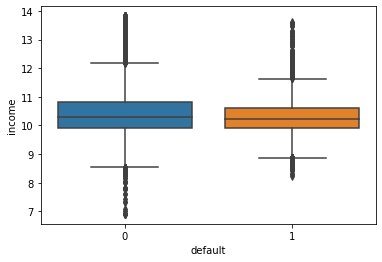

In [21]:
data['income'] = np.log(data['income'] + 1)
sns.boxplot(x='default',y = 'income',data=data)
    

### 3. Визуализация

10.752880921895006


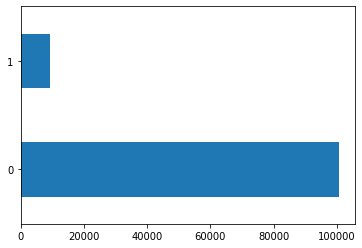

In [22]:
data['default'].value_counts().plot.barh()
print(len(data[data['default']==0])/len(data[data['default']==1]))

Как мы можем видеть, клиенты без дефолта преобладают нам клиентами с дефолтом почти в 11 раз.

Text(0.5, 1.0, 'income')

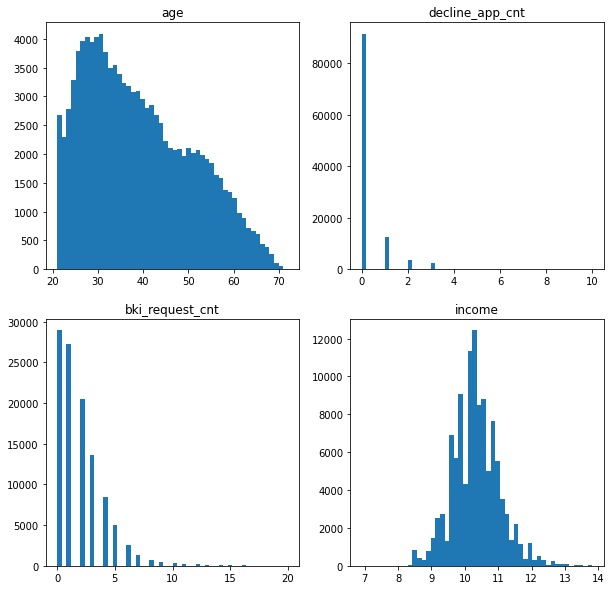

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

axes[0,0].hist(data['age'], bins = 50)
axes[0,0].set_title("age")

axes[0,1].hist(data['decline_app_cnt'], bins = 50, range=(0,10))
axes[0,1].set_title("decline_app_cnt")

axes[1,0].hist(data['bki_request_cnt'], bins = 50,  range=(0,20))
axes[1,0].set_title("bki_request_cnt")

axes[1,1].hist(data['income'], bins = 50)
axes[1,1].set_title("income")

По данным гистограммам можно сделать вывод, что распределения не являются нормальными и смещены вправо. При построении модели необходимо будет выполнить стандартизацию численных признаков.

### 4. Оценка корреляции

<AxesSubplot:>

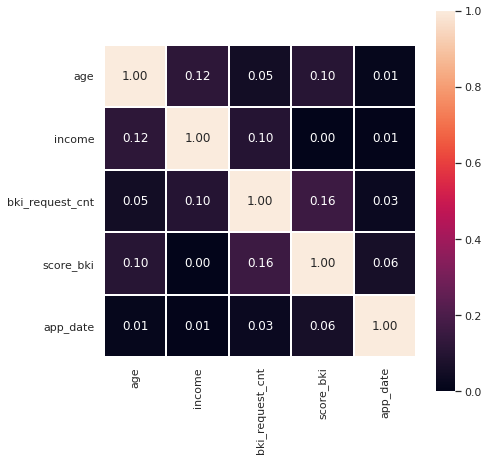

In [24]:
# Посмотрим матрицу коэффициента корреляции численных признаком
sns.set(font_scale = 1)
fig, axis = plt.subplots(figsize=(7,7))
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, square=True,
           annot=True, fmt=".2f", linewidths=0.1)

Исходя из данной матрицы корреляции видно, что признаки между собой скореллированы слабо. Поэтому оставим их все для модели.

### 5. Значимость непрерывных признаков

<AxesSubplot:>

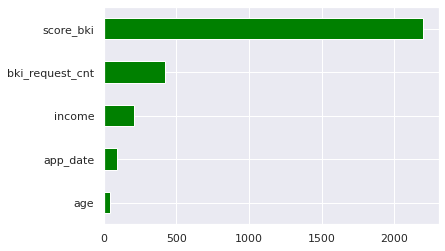

In [25]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', color='green')

Скоринговый балл по данным из БКИ (score_bki) является одним из самых значимых числовых признаков

### 6. Оценка категориальных признаков

In [26]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
data['education'] = label_encoder.fit_transform(data['education'])
# убедимся в преобразовании    
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,3,1,1,29,1,1,0,0,-2.271884,3,50,1,2,10.819798,1,4,0,0,0
1,17527,1,3,0,39,0,0,3,0,-1.504999,2,50,1,2,8.517393,4,3,0,0,0
2,75683,3,4,1,50,1,1,0,0,-1.691339,1,50,1,2,10.308986,1,3,1,0,0
3,26883,2,3,1,56,0,0,0,0,-2.374182,1,40,1,2,9.741027,1,3,0,0,0
4,28862,2,1,0,38,0,0,0,0,-2.487502,0,80,2,3,11.695255,1,3,0,0,0


<AxesSubplot:>

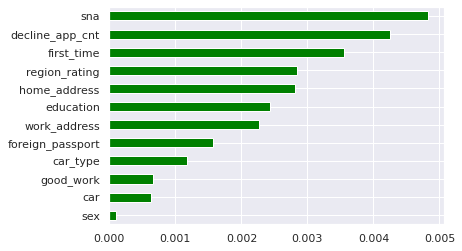

In [27]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', color='green')

Исходя из анализа mutual_info_classif наиболее важным из категориальных признаков является sna

### 7. Feature Engineering

In [28]:
# Переведем колонки region_rating, first_time и home_address из категориальных в численные,
# т.к. при их стандартизации значение метрики roc-auc получается выше, чем при создании из
# них dummy-переменных
cat_cols.remove('region_rating')
num_cols.append('region_rating')

cat_cols.remove('first_time')
num_cols.append('first_time')

cat_cols.remove('home_address')
num_cols.append('home_address')

### 8. Подготовка данных к машинному обучению

In [29]:
# Преобразуем категориальные признаки с помощью get_dummies
data = pd.get_dummies(data, columns=cat_cols)

In [30]:
# выполним стандартизацию численных переменных
data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]),
                              columns=num_cols)

In [31]:
# Разделим обратно на train и test
train = data.query('sample == 1').drop(['sample'], axis=1)
test = data.query('sample == 0').drop(['sample'], axis=1)

In [32]:
# удалим для X целевую переменную и client_id
X = train.drop(columns = ['default', 'client_id'])
Y = train['default']

In [33]:
# Разделим выборку на train и test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = RANDOM_SEED,
                                                    test_size=0.2)

### 9.Модели
#### 9.1 Логистическая регрессия

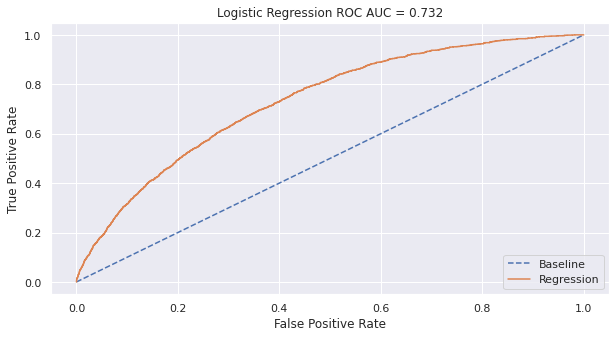

In [34]:
# Построим модель логистической регресии с параметрами "по умолчанию"
model = LogisticRegression()
model.fit(X_train, Y_train)
probs = model.predict_proba(X_test)
y_pred = model.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
ax.set_title('Logistic Regression ROC AUC = %0.3f'%roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

In [35]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, y_pred), 4)))

accuracy_score: 0.874
f1_score: 0.0606
recall_score: 0.0322
MSE: 0.126


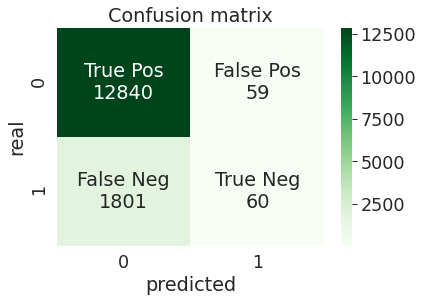

In [36]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='', cmap='Greens')
ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')
plt.show()

Рассмотрев матрицу ошибок, можно сделать вывод, что почти во всех случаях, когда клиент не способен выплатить кредит - модель все равно его выдаст. Данное решение приведет к падению доходов банка. Попробуем найти оптимальные гиперпараметры.

#### 9.1.1 Логистическая регрессия (гиперпараметры)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


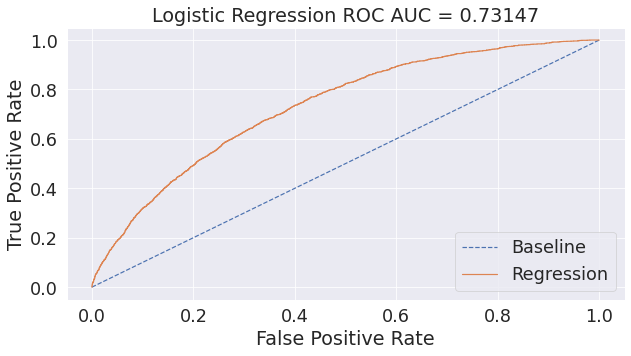

In [37]:
# Попробуем поменять class_weight и с помощью GridSearchCV найти оптимальные параметры
lr_best = LogisticRegression(class_weight='balanced',
                            random_state=RANDOM_SEED)

params = {'C': np.linspace(0, 100, 5),
         'max_iter': np.linspace(start=1,stop=1000,num=10, dtype=int)}

model_best = GridSearchCV(lr_best, param_grid=params, verbose=1, cv=2)

model_best.fit(X_train, Y_train)
probs = model_best.predict_proba(X_test)
y_pred = model_best.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
ax.set_title('Logistic Regression ROC AUC = %0.5f'%roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

In [38]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, y_pred), 4)))

accuracy_score: 0.6731
f1_score: 0.3362
recall_score: 0.6566
MSE: 0.3269


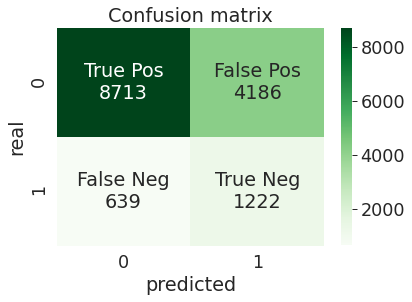

In [39]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='', cmap='Greens')
ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')
plt.show()

Как мы видим по confusion matrix наша модель достаточно много раз ошибается и не выдает кредит клиентам, которые его выплатят (точность сильно понизилась относительно model), что ведет к уменьшению доходов банка. Оданако теперь модель не выдает кредит всем в подряд...

#### 9.1.2 Логистическая регрессия (undersampling)

Так как в исходном датасете данные несбалансированные (один класс превосходит другой в 7 раз на train'е) можно попробовать выполнить undersampling, то есть случайным образом уменьшить преобладающий класс в 7 раз

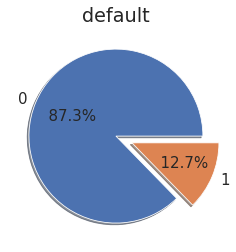

Класс 0 преобладает над классом 1 в 6.9 раз


In [40]:
plt.pie(x=train['default'].value_counts(),
       labels=list(train['default'].value_counts().index),
       autopct='%6.1f%%',
       explode=[0, 0.2],
       shadow=True,
       textprops={'fontsize': 15})
plt.title('default')
plt.show()

print('Класс 0 преобладает над классом 1 в {} раз'.format(
    round(train['default'].value_counts()[0]/train['default'].value_counts()[1],1)))

In [41]:
# Выберем случайным образом из train['default']==0 такое количество строк, которое
# равнялось бы train['default']==1, и затем объединим с train['default']==1.
under_train = pd.concat([train[train['default']==0].sample(
    len(train[train['default']==1]), random_state=RANDOM_SEED), train[train['default']==1]])

X = under_train.drop(columns = ['default', 'client_id'])
Y = under_train['default']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = RANDOM_SEED,
                                                    test_size=0.2)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
Лучшие параметры модели:  {'C': 100.0, 'max_iter': 56}


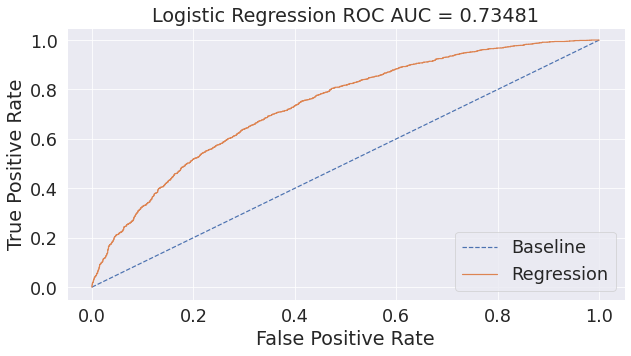

In [42]:
# Попробуем поменять class_weight и с помощью GridSearchCV найти оптимальные параметры
lr_best = LogisticRegression(class_weight='balanced',
                            random_state=RANDOM_SEED)

params = {'C': np.linspace(0, 100, 5),
         'max_iter': np.linspace(start=1,stop=500,num=10, dtype=int)}

model_best = GridSearchCV(lr_best, param_grid=params, verbose=1, cv=2)

model_best.fit(X_train, Y_train)
probs = model_best.predict_proba(X_test)
y_pred = model_best.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
ax.set_title('Logistic Regression ROC AUC = %0.5f'%roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

print("Лучшие параметры модели: ", model_best.best_params_)

In [43]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, y_pred), 4)))

accuracy_score: 0.6714
f1_score: 0.6773
recall_score: 0.6731
MSE: 0.3286


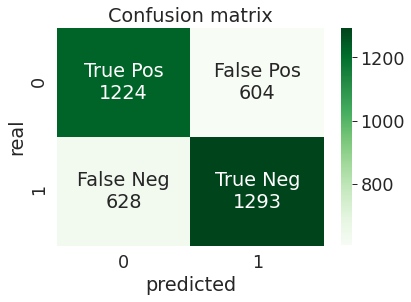

In [44]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='', cmap='Greens')
ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')
plt.show()

После проведения undersampling'а модель явно лучше стала предсказывать класс TrueNegative. В целом неплохо, но стоит попробовать более сложную модель...

#### 9.2 CatBoost

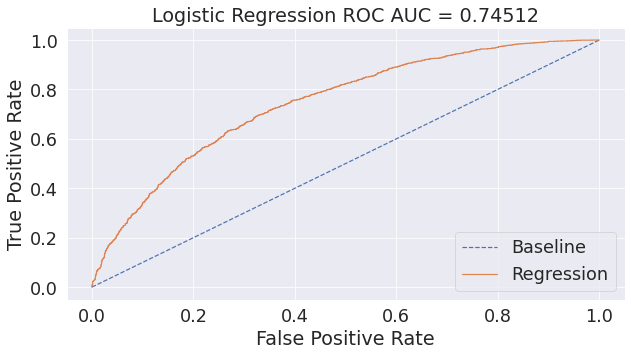

In [45]:
cat = CatBoostClassifier(n_estimators=1000,
                         depth=2,
                         logging_level='Silent')

cat.fit(X_train, Y_train)
probs = cat.predict_proba(X_test)
y_pred = cat.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
ax.set_title('Logistic Regression ROC AUC = %0.5f'%roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

In [46]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, y_pred), 4)))

accuracy_score: 0.6831
f1_score: 0.69
recall_score: 0.6882
MSE: 0.3169


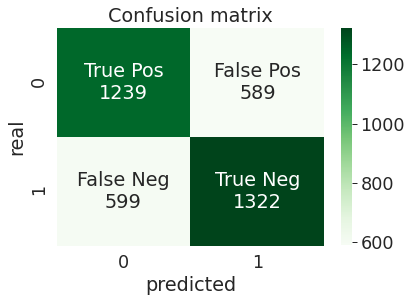

In [47]:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='', cmap='Greens')
ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')
plt.show()

Результаты стали лучше, чем были в модели логистической регресии с гиперпараметрами и выполненым undersampling'ом, поэтому для сабмишена будет использовать модель CatBoostingClassifier

In [48]:
X_test2 = test.drop(columns = ['default', 'client_id'])
y_probs = cat.predict_proba(X_test2)[:,1]

In [49]:
test['default'] = y_probs

In [50]:
submission = test[['client_id','default']]
display(submission.sample(10))
display(submission.shape)

,client_id,default
23854,16696,0.478736
14913,55266,0.842017
22203,93044,0.043107
10251,87977,0.243970
929,51069,0.500493
18480,106454,0.212702
32542,76402,0.283709
6685,46814,0.292083
600,18513,0.285631
31409,51726,0.869721


(36349, 2)

In [51]:
submission.to_csv('submission.csv', index=False)